In [1]:
import pylidc as pl
from pylidc.utils import consensus
import matplotlib.pyplot as plt
import numpy as np

In [2]:
MAX_NODULE_WIDTH = 100
MAX_NODULE_HEIGHT = 100

In [3]:
def zoomout_nodule(bbox, width, height):
    # TODO: what if is outside the picture?
    x_acres = (width - (bbox[0].stop - bbox[0].start))//2
    y_acres = (height - (bbox[1].stop - bbox[1].start))//2

    x_slice = slice(bbox[0].start - x_acres, bbox[0].stop + x_acres, None)
    y_slice = slice(bbox[1].start - y_acres, bbox[1].stop + y_acres, None)

    return (x_slice, y_slice, bbox[2])

Loading dicom files ... This may take a moment.


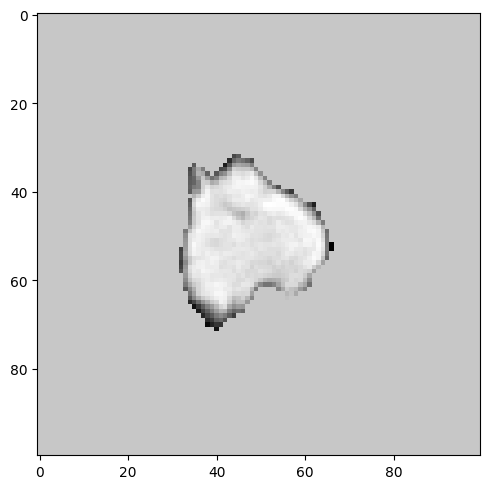

In [9]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
vol = scan.to_volume()

nods = scan.cluster_annotations()
anns = nods[0]

cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])

full_mask = np.full_like(vol, False, dtype=bool)
full_mask[cbbox] = cmask

cbbox = zoomout_nodule(cbbox, MAX_NODULE_WIDTH, MAX_NODULE_HEIGHT)
k = int(0.5*(cbbox[2].stop - cbbox[2].start))
cropped = vol[cbbox]
cropped[~full_mask[cbbox]] = 0

# Errado, a escala tem de ser igual entre imagens
cropped -= 1000
cropped = cropped / 1000

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(cropped[:,:,k], cmap=plt.cm.gray)

# Plot the 50% consensus contour for the kth slice.
# for c in find_contours(cmask[:,:,k].astype(float), 0.5):
#     plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

In [4]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
vol = scan.to_volume()

nods = scan.cluster_annotations()
anns = nods[0]

cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

Loading dicom files ... This may take a moment.


dtype('int16')

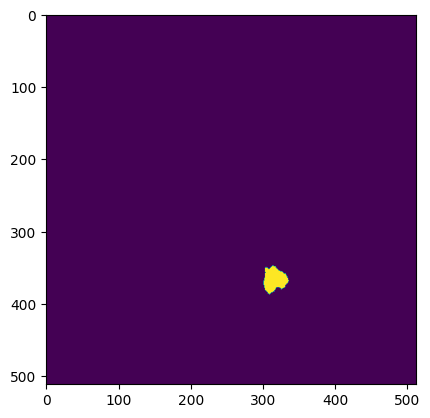

In [5]:
full_mask = np.full_like(vol, False)
full_mask[cbbox] = cmask
plt.imshow(full_mask[:,:,k+cbbox[2].start])
full_mask[:,:,k].any(), cmask[:,:,k].any(), full_mask[cbbox][:,:,k].any()
# plt.imshow(vol[cbbox][:,:,k])
full_mask.dtype

[[False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]]
[[False False False False False False False False False False]
 [False  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  Tru

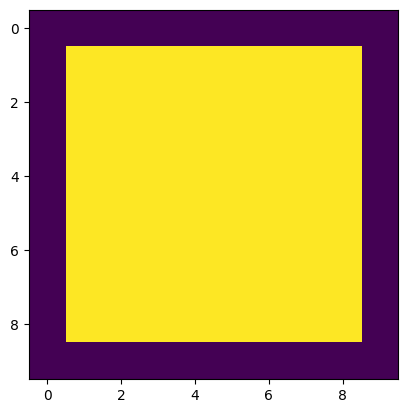

In [56]:
array = np.full((10,10), False)
print(array)
foo = (slice(np.int64(1), np.int64(9), None), slice(np.int64(1), np.int64(9), None))
array[foo] = True
print(array)
plt.imshow(array)

In [41]:
cmask.shape

(92, 84, 9)

In [17]:
cbbox

(slice(np.int64(320), np.int64(412), None),
 slice(np.int64(277), np.int64(361), None),
 slice(np.int64(76), np.int64(105), None))